## Загрузим нужные библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import numpy as np
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import classification_report
import math
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
%matplotlib inline


В этом примере мы попробуем предсказать итоговую оценку участинка только на основе **его действий**

In [2]:
df_train = pd.read_csv("train.csv")
df_user = pd.read_csv("user_decision.csv")

In [3]:
pd.DataFrame(df_user.groupby('user_id')['decision_id'].value_counts())

decision_id
user_id decision_id             
10001   25                     8
        26                     8
        27                     8
        31                     3
        32                     3
...                          ...
10973   304                    1
        306                    1
        344                    1
        386                    1
        427                    1

[44663 rows x 1 columns]

In [4]:
len(df_user['decision_id'].unique())

343

## Рассмотрим датасет по ближе

In [5]:
df_train.shape


(680, 5)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   680 non-null    int64  
 1   Analytical thinking  680 non-null    float64
 2   Systemic thinking    680 non-null    float64
 3   Adaptability         680 non-null    float64
 4   Focus                680 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 26.7 KB


In [7]:
df_train.head(30)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10884,4.0,4.0,4.0,4.0
1,10106,5.0,4.0,5.0,5.0
2,10438,6.0,5.0,5.0,5.0
3,10130,5.0,4.0,5.0,5.0
4,10667,4.0,5.0,5.0,5.0
5,10908,4.0,4.0,5.0,5.0
6,10378,4.0,5.0,5.0,4.0
7,10220,5.0,4.0,5.0,5.0
8,10612,5.0,4.0,4.0,5.0
9,10776,4.0,4.0,5.0,5.0


In [8]:
df_user.shape

(60228, 3)

In [9]:
df_user.head(3)

,user_id,period,decision_id
0,10625,1,409
1,10318,3,203
2,10775,4,420


In [10]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60228 entries, 0 to 60227
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      60228 non-null  int64
 1   period       60228 non-null  int64
 2   decision_id  60228 non-null  int64
dtypes: int64(3)
memory usage: 1.4 MB


Заметим что в есть категория где пользватель совершал больше действий

In [11]:
df_user.period.value_counts()

3    20964
4    14811
2    14453
1    10000
Name: period, dtype: int64

Пострим на распределение данных

Text(0.5, 1.0, 'Распределение периода')

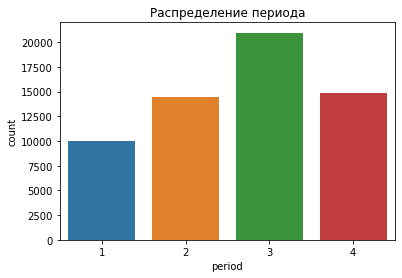

In [12]:
sns.countplot(x = "period" , data  = df_user).set_title('Распределение периода')

Text(0.5, 1.0, 'Распределение действий')

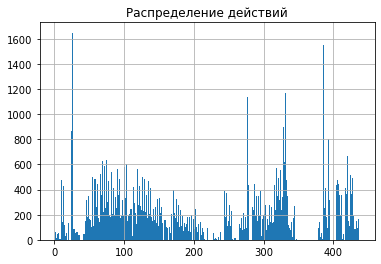

In [13]:
df_user["decision_id"].hist(bins = 300).set_title('Распределение действий')

### Добавим новых значений

Узнаем частоту команд участника в каждом периоде

In [14]:
df_user_train = df_user[df_user.user_id.map(lambda x:x in df_train.id.values)]
df_user_train

,user_id,period,decision_id
0,10625,1,409
2,10775,4,420
3,10236,2,284
4,10130,3,72
5,10273,2,140
...,...,...,...
60220,10528,1,88
60222,10832,3,315
60224,10189,1,33
60226,10424,2,140


In [15]:
df_decision_count = df_user_train.groupby(by=["user_id",	"period"]).count()

In [16]:
df_decision_count.head(5)

decision_id
user_id period             
10001   1                29
        2                23
        3                39
        4                15
10003   1                21

In [17]:
for id in df_train.id.values:
  for period in range(1,5):
    try :
      index = df_train[df_train.id == id].index[0]
      df_train.loc[index,"period_"+str(period)] = df_decision_count.loc[pd.IndexSlice[id, period:period], :].values[0][0]

    except IndexError:
      continue

In [18]:
df_train=df_train.fillna(df_train.mean())

In [19]:
df_decision_count_id = pd.DataFrame(df_user_train.groupby('user_id')['decision_id'].value_counts())
df_decision_count_id = df_decision_count_id.rename(columns={'decision_id': 'decision'})
df_decision_count_id.query('user_id==10001').shape

(64, 1)

In [20]:
df_decision_count_id.query('user_id==10001')

decision
user_id decision_id          
10001   25                  8
        26                  8
        27                  8
        31                  3
        32                  3
...                       ...
        383                 1
        384                 1
        386                 1
        388                 1
        410                 1

[64 rows x 1 columns]

In [21]:
pd.DataFrame(df_decision_count_id.loc[pd.IndexSlice[10001], :]).reset_index()[pd.DataFrame(df_decision_count_id.loc[pd.IndexSlice[10001], :]).reset_index()['decision_id'] == 25]['decision'].values[0]

8

for id in df_train.id.values:
  for period in range(1,343):
    try :
      index = df_train[df_train.id == id].index[0]
      df_train.loc[index,"decision_id"+str(period)] = pd.DataFrame(df_decision_count_id.loc[pd.IndexSlice[id], :]).reset_index()[pd.DataFrame(df_decision_count_id.loc[pd.IndexSlice[id], :]).reset_index()['decision_id'] == period]['decision'].values[0]
    except IndexError:
      continue

df_train.to_csv('df_trainmonstr.csv',index=False)

In [22]:
df_train=pd.read_csv('df_trainmonstr.csv')

In [23]:
pd.set_option('display.max_columns', None)

In [24]:
df_train.query('id==10001').head(1)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus,period_1,period_2,period_3,period_4,decision_id10,decision_id74,decision_id75,decision_id76,decision_id77,decision_id78,decision_id79,decision_id80,decision_id81,decision_id82,decision_id83,decision_id84,decision_id86,decision_id87,decision_id88,decision_id89,decision_id90,decision_id92,decision_id93,decision_id94,decision_id99,decision_id100,decision_id101,decision_id125,decision_id126,decision_id127,decision_id128,decision_id129,decision_id132,decision_id133,decision_id135,decision_id148,decision_id151,decision_id156,decision_id191,decision_id195,decision_id246,decision_id265,decision_id276,decision_id277,decision_id300,decision_id301,decision_id323,decision_id11,decision_id25,decision_id26,decision_id28,decision_id109,decision_id136,decision_id137,decision_id139,decision_id145,decision_id146,decision_id150,decision_id152,decision_id153,decision_id154,decision_id172,decision_id175,decision_id185,decision_id186,decision_id187,decision_id193,decision_id194,decision_id284,decision_id286,decision_id287,decision_id288,decision_id289,decision_id290,decision_id292,decision_id293,decision_id296,decision_id313,decision_id314,decision_id316,decision_id317,decision_id321,decision_id325,decision_id326,decision_id329,decision_id330,decision_id331,decision_id332,decision_id333,decision_id12,decision_id13,decision_id14,decision_id15,decision_id27,decision_id63,decision_id106,decision_id107,decision_id108,decision_id110,decision_id111,decision_id112,decision_id114,decision_id115,decision_id118,decision_id119,decision_id120,decision_id121,decision_id122,decision_id123,decision_id124,decision_id130,decision_id131,decision_id134,decision_id138,decision_id140,decision_id141,decision_id142,decision_id143,decision_id144,decision_id147,decision_id155,decision_id159,decision_id160,decision_id161,decision_id165,decision_id167,decision_id168,decision_id170,decision_id171,decision_id173,decision_id177,decision_id178,decision_id179,decision_id180,decision_id181,decision_id182,decision_id183,decision_id184,decision_id201,decision_id203,decision_id207,decision_id209,decision_id210,decision_id211,decision_id213,decision_id214,decision_id219,decision_id220,decision_id244,decision_id245,decision_id247,decision_id248,decision_id249,decision_id250,decision_id251,decision_id252,decision_id253,decision_id254,decision_id255,decision_id278,decision_id298,decision_id302,decision_id307,decision_id308,decision_id310,decision_id311,decision_id312,decision_id315,decision_id318,decision_id319,decision_id327,decision_id328,decision_id339,decision_id340,decision_id46,decision_id47,decision_id49,decision_id51,decision_id52,decision_id55,decision_id56,decision_id58,decision_id59,decision_id60,decision_id61,decision_id62,decision_id66,decision_id67,decision_id68,decision_id69,decision_id71,decision_id72,decision_id73,decision_id85,decision_id102,decision_id166,decision_id188,decision_id189,decision_id190,decision_id192,decision_id202,decision_id204,decision_id205,decision_id267,decision_id270,decision_id274,decision_id275,decision_id291,decision_id320,decision_id322,decision_id324,decision_id334,decision_id336,decision_id1,decision_id6,decision_id17,decision_id21,decision_id42,decision_id44,decision_id48,decision_id50,decision_id91,decision_id96,decision_id103,decision_id104,decision_id174,decision_id176,decision_id199,decision_id200,decision_id206,decision_id229,decision_id239,decision_id272,decision_id273,decision_id285,decision_id294,decision_id295,decision_id304,decision_id335,decision_id338,decision_id53,decision_id54,decision_id105,decision_id113,decision_id266,decision_id268,decision_id269,decision_id4,decision_id29,decision_id34,decision_id149,decision_id116,decision_id197,decision_id303,decision_id309,decision_id97,decision_id306,decision_id18,decision_id65,decision_id30,decision_id31,decision_id32,decision_id35,decision_id36,decision_id95,decision_id216,decision_id232,decision_id271,decision_id98,decisio

In [25]:
df_train=df_train.fillna(0)

In [26]:
df_train.isna().sum()

id                     0
Analytical thinking    0
Systemic thinking      0
Adaptability           0
Focus                  0
                      ..
decision_id256         0
decision_id259         0
decision_id231         0
decision_id233         0
decision_id5           0
Length: 298, dtype: int64

In [27]:
df_train['sum']=df_train['period_1']+df_train['period_2']+df_train['period_3']+df_train['period_4']
df_train['quad']=df_train['period_1'] * df_train['period_1'] + df_train['period_2'] * df_train['period_2'] + df_train['period_3'] * df_train['period_3'] + df_train['period_4'] * df_train['period_4']
df_train['medan']=(df_train['period_1']+df_train['period_2']+df_train['period_3']+df_train['period_4'])/4
df_train['sqr_median']=np.sqrt(df_train['medan'])
df_train['sqr_sum']=np.sqrt(df_train['sum'])

In [28]:
df_train=df_train.sort_index(axis = 1)
 

In [29]:
df_train

,Adaptability,Analytical thinking,Focus,Systemic thinking,decision_id1,decision_id10,decision_id100,decision_id101,decision_id102,decision_id103,decision_id104,decision_id105,decision_id106,decision_id107,decision_id108,decision_id109,decision_id11,decision_id110,decision_id111,decision_id112,decision_id113,decision_id114,decision_id115,decision_id116,decision_id117,decision_id118,decision_id119,decision_id12,decision_id120,decision_id121,decision_id122,decision_id123,decision_id124,decision_id125,decision_id126,decision_id127,decision_id128,decision_id129,decision_id13,decision_id130,decision_id131,decision_id132,decision_id133,decision_id134,decision_id135,decision_id136,decision_id137,decision_id138,decision_id139,decision_id14,decision_id140,decision_id141,decision_id142,decision_id143,decision_id144,decision_id145,decision_id146,decision_id147,decision_id148,decision_id149,decision_id15,decision_id150,decision_id151,decision_id152,decision_id153,decision_id154,decision_id155,decision_id156,decision_id159,decision_id16,decision_id160,decision_id161,decision_id165,decision_id166,decision_id167,decision_id168,decision_id17,decision_id170,decision_id171,decision_id172,decision_id173,decision_id174,decision_id175,decision_id176,decision_id177,decision_id178,decision_id179,decision_id18,decision_id180,decision_id181,decision_id182,decision_id183,decision_id184,decision_id185,decision_id186,decision_id187,decision_id188,decision_id189,decision_id190,decision_id191,decision_id192,decision_id193,decision_id194,decision_id195,decision_id196,decision_id197,decision_id199,decision_id200,decision_id201,decision_id202,decision_id203,decision_id204,decision_id205,decision_id206,decision_id207,decision_id209,decision_id21,decision_id210,decision_id211,decision_id212,decision_id213,decision_id214,decision_id216,decision_id219,decision_id220,decision_id228,decision_id229,decision_id230,decision_id231,decision_id232,decision_id233,decision_id235,decision_id239,decision_id244,decision_id245,decision_id246,decision_id247,decision_id248,decision_id249,decision_id25,decision_id250,decision_id251,decision_id252,decision_id253,decision_id254,decision_id255,decision_id256,decision_id259,decision_id26,decision_id265,decision_id266,decision_id267,decision_id268,decision_id269,decision_id27,decision_id270,decision_id271,decision_id272,decision_id273,decision_id274,decision_id275,decision_id276,decision_id277,decision_id278,decision_id28,decision_id284,decision_id285,decision_id286,decision_id287,decision_id288,decision_id289,decision_id29,decision_id290,decision_id291,decision_id292,decision_id293,decision_id294,decision_id295,decision_id296,decision_id297,decision_id298,decision_id3,decision_id30,decision_id300,decision_id301,decision_id302,decision_id303,decision_id304,decision_id306,decision_id307,decision_id308,decision_id309,decision_id31,decision_id310,decision_id311,decision_id312,decision_id313,decision_id314,decision_id315,decision_id316,decision_id317,decision_id318,decision_id319,decision_id32,decision_id320,decision_id321,decision_id322,decision_id323,decision_id324,decision_id325,decision_id326,decision_id327,decision_id328,decision_id329,decision_id33,decision_id330,decision_id331,decision_id332,decision_id333,decision_id334,decision_id335,decision_id336,decision_id337,decision_id338,decision_id339,decision_id34,decision_id340,decision_id341,decision_id342,decision_id35,decision_id36,decision_id4,decision_id42,decision_id44,decision_id46,decision_id47,decision_id48,decision_id49,decision_id5,decision_id50,decision_id51,decision_id52,decision_id53,decision_id54,decision_id55,decision_id56,decision_id57,decision_id58,decision_id59,decision_id6,decision_id60,decision_id61,decision_id62,decision_id63,decision_id64,decision_id65,decision_id66,decision_id67,decision_id68,decision_id69,decision_id7,decision_id70,decision_id71,decision_id72,decision_id73,decision_id74,decision_id75,decision_id76,decision_id77,decision_id78,decision_id79,decisio

In [30]:
df_train=df_train.append(df_train)

/tmp/ipykernel_665028/1467900330.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train=df_train.append(df_train)


In [31]:

df_train['Focus'].value_counts()

4.0    800
5.0    488
3.0     58
6.0      6
1.0      6
2.0      2
Name: Focus, dtype: int64


focus1=df_train.query("Adaptability==2").head()
focus2=df_train.query("Adaptability==1").head()
focus3=df_train.query("Adaptability==6").head()
focus4=df_train.query("Adaptability==3").head()
for i in range(1,10):
    df_train=df_train.append(focus1, ignore_index=True)
    df_train=df_train.append(focus2, ignore_index=True)
    df_train=df_train.append(focus3, ignore_index=True)
    df_train=df_train.append(focus4, ignore_index=True)

In [32]:
df_train['Adaptability'].value_counts()

5.0    636
4.0    616
3.0     72
6.0     30
1.0      4
2.0      2
Name: Adaptability, dtype: int64

In [33]:
df_train=df_train.query('Adaptability!=2')
df_train=df_train.query('Focus!=2')

In [34]:
df_train

,Adaptability,Analytical thinking,Focus,Systemic thinking,decision_id1,decision_id10,decision_id100,decision_id101,decision_id102,decision_id103,decision_id104,decision_id105,decision_id106,decision_id107,decision_id108,decision_id109,decision_id11,decision_id110,decision_id111,decision_id112,decision_id113,decision_id114,decision_id115,decision_id116,decision_id117,decision_id118,decision_id119,decision_id12,decision_id120,decision_id121,decision_id122,decision_id123,decision_id124,decision_id125,decision_id126,decision_id127,decision_id128,decision_id129,decision_id13,decision_id130,decision_id131,decision_id132,decision_id133,decision_id134,decision_id135,decision_id136,decision_id137,decision_id138,decision_id139,decision_id14,decision_id140,decision_id141,decision_id142,decision_id143,decision_id144,decision_id145,decision_id146,decision_id147,decision_id148,decision_id149,decision_id15,decision_id150,decision_id151,decision_id152,decision_id153,decision_id154,decision_id155,decision_id156,decision_id159,decision_id16,decision_id160,decision_id161,decision_id165,decision_id166,decision_id167,decision_id168,decision_id17,decision_id170,decision_id171,decision_id172,decision_id173,decision_id174,decision_id175,decision_id176,decision_id177,decision_id178,decision_id179,decision_id18,decision_id180,decision_id181,decision_id182,decision_id183,decision_id184,decision_id185,decision_id186,decision_id187,decision_id188,decision_id189,decision_id190,decision_id191,decision_id192,decision_id193,decision_id194,decision_id195,decision_id196,decision_id197,decision_id199,decision_id200,decision_id201,decision_id202,decision_id203,decision_id204,decision_id205,decision_id206,decision_id207,decision_id209,decision_id21,decision_id210,decision_id211,decision_id212,decision_id213,decision_id214,decision_id216,decision_id219,decision_id220,decision_id228,decision_id229,decision_id230,decision_id231,decision_id232,decision_id233,decision_id235,decision_id239,decision_id244,decision_id245,decision_id246,decision_id247,decision_id248,decision_id249,decision_id25,decision_id250,decision_id251,decision_id252,decision_id253,decision_id254,decision_id255,decision_id256,decision_id259,decision_id26,decision_id265,decision_id266,decision_id267,decision_id268,decision_id269,decision_id27,decision_id270,decision_id271,decision_id272,decision_id273,decision_id274,decision_id275,decision_id276,decision_id277,decision_id278,decision_id28,decision_id284,decision_id285,decision_id286,decision_id287,decision_id288,decision_id289,decision_id29,decision_id290,decision_id291,decision_id292,decision_id293,decision_id294,decision_id295,decision_id296,decision_id297,decision_id298,decision_id3,decision_id30,decision_id300,decision_id301,decision_id302,decision_id303,decision_id304,decision_id306,decision_id307,decision_id308,decision_id309,decision_id31,decision_id310,decision_id311,decision_id312,decision_id313,decision_id314,decision_id315,decision_id316,decision_id317,decision_id318,decision_id319,decision_id32,decision_id320,decision_id321,decision_id322,decision_id323,decision_id324,decision_id325,decision_id326,decision_id327,decision_id328,decision_id329,decision_id33,decision_id330,decision_id331,decision_id332,decision_id333,decision_id334,decision_id335,decision_id336,decision_id337,decision_id338,decision_id339,decision_id34,decision_id340,decision_id341,decision_id342,decision_id35,decision_id36,decision_id4,decision_id42,decision_id44,decision_id46,decision_id47,decision_id48,decision_id49,decision_id5,decision_id50,decision_id51,decision_id52,decision_id53,decision_id54,decision_id55,decision_id56,decision_id57,decision_id58,decision_id59,decision_id6,decision_id60,decision_id61,decision_id62,decision_id63,decision_id64,decision_id65,decision_id66,decision_id67,decision_id68,decision_id69,decision_id7,decision_id70,decision_id71,decision_id72,decision_id73,decision_id74,decision_id75,decision_id76,decision_id77,decision_id78,decision_id79,decisio

In [35]:
len(list(df_train.columns.values))

303

In [36]:
df_train['Focus'].value_counts()

4.0    800
5.0    488
3.0     58
6.0      6
1.0      6
Name: Focus, dtype: int64

In [37]:
df_train['Adaptability'].value_counts()

5.0    636
4.0    616
3.0     72
6.0     30
1.0      4
Name: Adaptability, dtype: int64

focus2=df_train.query("Adaptability==1").head(25)
for i in range(1,10):
    df_train=df_train.append(focus2, ignore_index=True)
    

focus2=df_train.query("Focus==1").head(25)
focus3=df_train.query("Focus==6").head(25)
for i in range(1,5):
    df_train=df_train.append(focus2, ignore_index=True)
    df_train=df_train.append(focus3, ignore_index=True)

## Выделим выборки

In [38]:
X = df_train.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
y = df_train['Analytical thinking']

In [39]:
X.shape

(1358, 298)

In [40]:
X

,decision_id1,decision_id10,decision_id100,decision_id101,decision_id102,decision_id103,decision_id104,decision_id105,decision_id106,decision_id107,decision_id108,decision_id109,decision_id11,decision_id110,decision_id111,decision_id112,decision_id113,decision_id114,decision_id115,decision_id116,decision_id117,decision_id118,decision_id119,decision_id12,decision_id120,decision_id121,decision_id122,decision_id123,decision_id124,decision_id125,decision_id126,decision_id127,decision_id128,decision_id129,decision_id13,decision_id130,decision_id131,decision_id132,decision_id133,decision_id134,decision_id135,decision_id136,decision_id137,decision_id138,decision_id139,decision_id14,decision_id140,decision_id141,decision_id142,decision_id143,decision_id144,decision_id145,decision_id146,decision_id147,decision_id148,decision_id149,decision_id15,decision_id150,decision_id151,decision_id152,decision_id153,decision_id154,decision_id155,decision_id156,decision_id159,decision_id16,decision_id160,decision_id161,decision_id165,decision_id166,decision_id167,decision_id168,decision_id17,decision_id170,decision_id171,decision_id172,decision_id173,decision_id174,decision_id175,decision_id176,decision_id177,decision_id178,decision_id179,decision_id18,decision_id180,decision_id181,decision_id182,decision_id183,decision_id184,decision_id185,decision_id186,decision_id187,decision_id188,decision_id189,decision_id190,decision_id191,decision_id192,decision_id193,decision_id194,decision_id195,decision_id196,decision_id197,decision_id199,decision_id200,decision_id201,decision_id202,decision_id203,decision_id204,decision_id205,decision_id206,decision_id207,decision_id209,decision_id21,decision_id210,decision_id211,decision_id212,decision_id213,decision_id214,decision_id216,decision_id219,decision_id220,decision_id228,decision_id229,decision_id230,decision_id231,decision_id232,decision_id233,decision_id235,decision_id239,decision_id244,decision_id245,decision_id246,decision_id247,decision_id248,decision_id249,decision_id25,decision_id250,decision_id251,decision_id252,decision_id253,decision_id254,decision_id255,decision_id256,decision_id259,decision_id26,decision_id265,decision_id266,decision_id267,decision_id268,decision_id269,decision_id27,decision_id270,decision_id271,decision_id272,decision_id273,decision_id274,decision_id275,decision_id276,decision_id277,decision_id278,decision_id28,decision_id284,decision_id285,decision_id286,decision_id287,decision_id288,decision_id289,decision_id29,decision_id290,decision_id291,decision_id292,decision_id293,decision_id294,decision_id295,decision_id296,decision_id297,decision_id298,decision_id3,decision_id30,decision_id300,decision_id301,decision_id302,decision_id303,decision_id304,decision_id306,decision_id307,decision_id308,decision_id309,decision_id31,decision_id310,decision_id311,decision_id312,decision_id313,decision_id314,decision_id315,decision_id316,decision_id317,decision_id318,decision_id319,decision_id32,decision_id320,decision_id321,decision_id322,decision_id323,decision_id324,decision_id325,decision_id326,decision_id327,decision_id328,decision_id329,decision_id33,decision_id330,decision_id331,decision_id332,decision_id333,decision_id334,decision_id335,decision_id336,decision_id337,decision_id338,decision_id339,decision_id34,decision_id340,decision_id341,decision_id342,decision_id35,decision_id36,decision_id4,decision_id42,decision_id44,decision_id46,decision_id47,decision_id48,decision_id49,decision_id5,decision_id50,decision_id51,decision_id52,decision_id53,decision_id54,decision_id55,decision_id56,decision_id57,decision_id58,decision_id59,decision_id6,decision_id60,decision_id61,decision_id62,decision_id63,decision_id64,decision_id65,decision_id66,decision_id67,decision_id68,decision_id69,decision_id7,decision_id70,decision_id71,decision_id72,decision_id73,decision_id74,decision_id75,decision_id76,decision_id77,decision_id78,decision_id79,decision_id8,decision_id80,decision_id81,decision_id82,decision_

In [41]:
X.isna().sum()

decision_id1      0
decision_id10     0
decision_id100    0
decision_id101    0
decision_id102    0
                 ..
period_4          0
quad              0
sqr_median        0
sqr_sum           0
sum               0
Length: 298, dtype: int64

In [42]:
y

0      4.0
1      5.0
2      6.0
3      5.0
4      4.0
      ... 
675    5.0
676    5.0
677    5.0
678    4.0
679    4.0
Name: Analytical thinking, Length: 1358, dtype: float64

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Обучение модели

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
rf_model_Analytical_thinking = LogisticRegression() # Ваш код здесь
# обучим модель случайного леса
rf_model_Analytical_thinking.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=11, n_estimators=50)

## Оценка точности

In [45]:
pred = rf_model_Analytical_thinking.predict(X_test)

In [46]:
pred

array([4., 4., 5., 4., 4., 4., 5., 5., 4., 4., 4., 4., 4., 4., 4., 5., 4.,
       4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       5., 4., 5., 5., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 5., 4.,
       5., 4., 5., 4., 4., 5., 5., 4., 4., 4., 6., 4., 4., 4., 5., 4., 4.,
       4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 5.,
       4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4.,
       4., 5., 4., 4., 5., 5., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 5., 5., 4., 4., 4., 4., 4., 4., 5., 4., 4., 5., 4., 6.,
       4., 4., 4., 5., 4., 4., 5., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4.,
       5., 4., 5., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 5., 4., 4.,
       4., 5., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 5., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4.,
       6., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 1., 4., 4., 4., 4.,
       4., 5., 5., 4., 4.

In [47]:

print (classification_report(y_test, pred))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         2
         3.0       1.00      0.29      0.44         7
         4.0       0.80      0.98      0.88       175
         5.0       0.92      0.55      0.69        83
         6.0       1.00      0.80      0.89         5

    accuracy                           0.83       272
   macro avg       0.94      0.72      0.78       272
weighted avg       0.85      0.83      0.81       272



rf_model =  RandomForestClassifier(n_jobs=-1)
from sklearn.model_selection import GridSearchCV
parametrs = { 'n_estimators': range (10, 51, 5),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,1) }

grid = GridSearchCV(rf_model, parametrs, cv=5,n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_params_

In [48]:
X = df_train.drop(['Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
y = df_train['Systemic thinking']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model_Systemic_thinking =  RandomForestClassifier(criterion='entropy' ,max_depth=11,min_samples_leaf=1,min_samples_split=2,n_estimators=50) # Ваш код здесь
# обучим модель случайного леса
rf_model_Systemic_thinking.fit(X_train, y_train)
pred = rf_model_Systemic_thinking.predict(X_test)
print (classification_report(y_test, pred))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         1
         3.0       1.00      0.33      0.50        15
         4.0       0.82      1.00      0.90       204
         5.0       1.00      0.26      0.41        46
         6.0       1.00      0.83      0.91         6

    accuracy                           0.83       272
   macro avg       0.96      0.69      0.74       272
weighted avg       0.86      0.83      0.80       272



param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(X_train, y_train)
print(nbModel_grid.best_estimator_)

In [49]:
X = df_train.drop(['Adaptability', 'Focus','id'], axis = 1)
y = df_train['Adaptability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model_Adaptability =  RandomForestClassifier(criterion='entropy' ,max_depth=11,min_samples_leaf=1,min_samples_split=2,n_estimators=50) # Ваш код здесь
# обучим модель случайного леса
rf_model_Adaptability.fit(X_train, y_train)
pred = rf_model_Adaptability.predict(X_test)
print (classification_report(y_test, pred))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         1
         3.0       1.00      0.18      0.31        11
         4.0       0.79      0.97      0.87       131
         5.0       0.96      0.79      0.87       119
         6.0       1.00      1.00      1.00        10

    accuracy                           0.86       272
   macro avg       0.95      0.79      0.81       272
weighted avg       0.88      0.86      0.85       272



param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(X_train, y_train)
print(nbModel_grid.best_estimator_)

In [50]:
X = df_train.drop(['Focus','id'], axis = 1)
y = df_train['Focus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model_Focus =  RandomForestClassifier(criterion='entropy' ,max_depth=11,min_samples_leaf=1,min_samples_split=2,n_estimators=50) # Ваш код здесь
# обучим модель случайного леса
rf_model_Focus.fit(X_train, y_train)
pred = rf_model_Focus.predict(X_test)
print (classification_report(y_test, pred))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         1
         3.0       1.00      0.15      0.27        13
         4.0       0.79      0.97      0.87       154
         5.0       0.95      0.73      0.82       103
         6.0       1.00      1.00      1.00         1

    accuracy                           0.84       272
   macro avg       0.95      0.77      0.79       272
weighted avg       0.86      0.84      0.83       272



param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
nbModel_grid = GridSearchCV(estimator=GaussianNB(var_smoothing=0.0001519911082952933), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(X_train, y_train)
print(nbModel_grid.best_estimator_)

In [51]:
# Предикт.

In [52]:
datapre=pd.read_csv('sample_solution.csv')

In [53]:
datapre

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10199,0,0,0,0
1,10539,0,0,0,0
2,10174,0,0,0,0
3,10465,0,0,0,0
4,10066,0,0,0,0
...,...,...,...,...,...
288,10433,0,0,0,0
289,10893,0,0,0,0
290,10909,0,0,0,0
291,10889,0,0,0,0


In [54]:
df_user_train = df_user[df_user.user_id.map(lambda x:x in datapre.id.values)]

In [55]:
df_decision_count = df_user_train.groupby(by=["user_id",	"period"]).count()

In [56]:
df_decision_count.head(5)

decision_id
user_id period             
10002   2                 9
        3                25
        4                22
10005   1                14
        2                34

In [57]:
for id in datapre.id.values:
  for period in range(1,5):
    try :
      index = datapre[datapre.id == id].index[0]
      datapre.loc[index,"period_"+str(period)] = df_decision_count.loc[pd.IndexSlice[id, period:period], :].values[0][0]
    except IndexError:
      continue

In [58]:
datapre=datapre.fillna(datapre.mean())

In [59]:
df_decision_count_id = pd.DataFrame(df_user.groupby('user_id')['decision_id'].value_counts())
df_decision_count_id = df_decision_count_id.rename(columns={'decision_id': 'decision'})
df_decision_count_id.query('user_id==10001').shape

(64, 1)

for id in datapre.id.values:
  for period in range(1,343):
    try :
      index = datapre[datapre.id == id].index[0]
      datapre.loc[index,"decision_id"+str(period)] = pd.DataFrame(df_decision_count_id.loc[pd.IndexSlice[id], :]).reset_index()[pd.DataFrame(df_decision_count_id.loc[pd.IndexSlice[id], :]).reset_index()['decision_id'] == period]['decision'].values[0]
    except IndexError:
      continue

datapre=datapre.fillna(0)

datapre

datapre.to_csv('datapremonstr.csv',index=False)

In [60]:
datapre=pd.read_csv('datapremonstr.csv')
datapre=datapre.sort_index(axis = 1)

In [61]:
datapre

,Adaptability,Analytical thinking,Focus,Systemic thinking,decision_id1,decision_id10,decision_id100,decision_id101,decision_id102,decision_id103,decision_id104,decision_id105,decision_id106,decision_id107,decision_id108,decision_id109,decision_id11,decision_id110,decision_id111,decision_id112,decision_id113,decision_id114,decision_id115,decision_id116,decision_id117,decision_id118,decision_id119,decision_id12,decision_id120,decision_id121,decision_id122,decision_id123,decision_id124,decision_id125,decision_id126,decision_id127,decision_id128,decision_id129,decision_id13,decision_id130,decision_id131,decision_id132,decision_id133,decision_id134,decision_id135,decision_id136,decision_id137,decision_id138,decision_id139,decision_id14,decision_id140,decision_id141,decision_id142,decision_id143,decision_id144,decision_id145,decision_id146,decision_id147,decision_id148,decision_id149,decision_id15,decision_id150,decision_id151,decision_id152,decision_id153,decision_id154,decision_id155,decision_id156,decision_id159,decision_id16,decision_id160,decision_id161,decision_id165,decision_id166,decision_id167,decision_id168,decision_id17,decision_id170,decision_id171,decision_id172,decision_id173,decision_id174,decision_id175,decision_id176,decision_id177,decision_id178,decision_id179,decision_id18,decision_id180,decision_id181,decision_id182,decision_id183,decision_id184,decision_id185,decision_id186,decision_id187,decision_id188,decision_id189,decision_id190,decision_id191,decision_id192,decision_id193,decision_id194,decision_id195,decision_id196,decision_id197,decision_id199,decision_id200,decision_id201,decision_id202,decision_id203,decision_id204,decision_id205,decision_id206,decision_id207,decision_id209,decision_id21,decision_id210,decision_id211,decision_id212,decision_id213,decision_id214,decision_id219,decision_id220,decision_id228,decision_id229,decision_id230,decision_id231,decision_id232,decision_id233,decision_id235,decision_id239,decision_id244,decision_id245,decision_id246,decision_id247,decision_id248,decision_id249,decision_id25,decision_id250,decision_id251,decision_id252,decision_id253,decision_id254,decision_id255,decision_id256,decision_id258,decision_id259,decision_id26,decision_id261,decision_id265,decision_id266,decision_id267,decision_id268,decision_id269,decision_id27,decision_id270,decision_id271,decision_id272,decision_id273,decision_id274,decision_id275,decision_id276,decision_id277,decision_id278,decision_id28,decision_id284,decision_id285,decision_id286,decision_id287,decision_id288,decision_id289,decision_id29,decision_id290,decision_id291,decision_id292,decision_id293,decision_id294,decision_id295,decision_id296,decision_id297,decision_id298,decision_id3,decision_id30,decision_id300,decision_id301,decision_id302,decision_id303,decision_id304,decision_id306,decision_id307,decision_id308,decision_id309,decision_id31,decision_id310,decision_id311,decision_id312,decision_id313,decision_id314,decision_id315,decision_id316,decision_id317,decision_id318,decision_id319,decision_id32,decision_id320,decision_id321,decision_id322,decision_id323,decision_id324,decision_id325,decision_id326,decision_id327,decision_id328,decision_id329,decision_id33,decision_id330,decision_id331,decision_id332,decision_id333,decision_id334,decision_id335,decision_id336,decision_id337,decision_id338,decision_id339,decision_id34,decision_id340,decision_id341,decision_id342,decision_id35,decision_id36,decision_id4,decision_id42,decision_id44,decision_id46,decision_id47,decision_id48,decision_id49,decision_id5,decision_id50,decision_id51,decision_id52,decision_id53,decision_id54,decision_id55,decision_id56,decision_id57,decision_id58,decision_id59,decision_id6,decision_id60,decision_id61,decision_id62,decision_id63,decision_id64,decision_id65,decision_id66,decision_id67,decision_id68,decision_id69,decision_id7,decision_id70,decision_id71,decision_id72,decision_id73,decision_id74,decision_id75,decision_id76,decision_id77,decision_id78,decisi

In [62]:
lst2=list(datapre.columns.values)
lst1=list(df_train.columns.values)

result = list(set(lst1) - set(lst2))

result


['decision_id9',
 'medan',
 'quad',
 'decision_id8',
 'sqr_sum',
 'decision_id216',
 'sqr_median',
 'sum']

In [63]:
datapre['sum']=datapre['period_1']+datapre['period_2']+datapre['period_3']+datapre['period_4']
datapre['quad']=datapre['period_1'] * datapre['period_1'] + datapre['period_2'] * datapre['period_2'] + datapre['period_3'] * datapre['period_3'] + datapre['period_4'] * datapre['period_4']
datapre['medan']=(datapre['period_1']+datapre['period_2']+datapre['period_3']+datapre['period_4'])/4
datapre['sqr_median']=np.sqrt(datapre['medan'])
datapre['sqr_sum']=np.sqrt(datapre['sum'])

In [64]:
lst2=list(datapre.columns.values)
lst1=list(df_train.columns.values)

result = list(set(lst1) - set(lst2))

result

['decision_id216', 'decision_id8', 'decision_id9']

In [65]:
datapre['decision_id8']=0

In [66]:
X = datapre.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)

pred_Analytical_thinking = rf_model_Analytical_thinking.predict(X)
pred_Analytical_thinking

/home/gennalll/.local/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- decision_id258
- decision_id261
Feature names seen at fit time, yet now missing:
- decision_id216
- decision_id9

  warnings.warn(message, FutureWarning)


array([4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       5., 4., 4., 4., 5., 4., 5., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       5., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 5., 4., 4., 4., 5., 4.,
       4., 5., 5., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5.,
       4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       5., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 5., 4., 4., 5.,
       4., 4., 4., 4., 4.

In [67]:
X = datapre.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
X['Analytical_thinking']=pred_Analytical_thinking
pred_Systemic_thinking = rf_model_Systemic_thinking.predict(X)
pred_Systemic_thinking

/home/gennalll/.local/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Analytical_thinking
- decision_id258
- decision_id261
Feature names seen at fit time, yet now missing:
- Analytical thinking
- decision_id216
- decision_id9

  warnings.warn(message, FutureWarning)


array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       5., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4.,
       5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4.

In [68]:
X = datapre.drop(['Adaptability', 'Focus','id'], axis = 1)
X['Systemic thinking']=pred_Systemic_thinking
pred_Adaptability = rf_model_Adaptability.predict(X)
pred_Adaptability

/home/gennalll/.local/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- decision_id258
- decision_id261
Feature names seen at fit time, yet now missing:
- decision_id216
- decision_id9

  warnings.warn(message, FutureWarning)


array([4., 5., 5., 5., 4., 4., 5., 4., 4., 4., 4., 5., 4., 5., 4., 4., 5.,
       4., 5., 5., 5., 5., 5., 4., 4., 5., 4., 4., 5., 4., 4., 5., 4., 5.,
       5., 4., 4., 4., 5., 4., 5., 4., 4., 4., 5., 4., 5., 5., 4., 4., 5.,
       5., 5., 4., 4., 5., 4., 4., 4., 4., 5., 5., 4., 4., 5., 5., 5., 5.,
       5., 4., 5., 4., 5., 4., 4., 5., 4., 5., 5., 4., 4., 4., 4., 4., 5.,
       5., 4., 4., 5., 4., 5., 4., 4., 4., 5., 4., 5., 4., 5., 4., 5., 4.,
       5., 4., 5., 4., 4., 5., 4., 5., 5., 5., 5., 5., 5., 5., 5., 5., 4.,
       5., 5., 5., 5., 4., 4., 4., 4., 5., 5., 5., 4., 4., 5., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5., 4., 4., 4., 4.,
       4., 4., 5., 4., 4., 5., 5., 4., 5., 4., 5., 4., 5., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 5., 5., 4., 5., 4., 4., 4., 5., 5., 5., 5., 5.,
       4., 4., 4., 4., 5., 4., 5., 4., 5., 4., 4., 4., 5., 5., 5., 4., 4.,
       5., 5., 4., 4., 4., 5., 4., 5., 5., 4., 4., 5., 4., 5., 5., 4., 4.,
       4., 4., 4., 4., 4.

In [69]:
X = datapre.drop(['Focus','id'], axis = 1)
X['Adaptability']=pred_Adaptability
pred_Focus = rf_model_Focus.predict(X)
len(pred_Focus)

/home/gennalll/.local/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- decision_id258
- decision_id261
Feature names seen at fit time, yet now missing:
- decision_id216
- decision_id9

  warnings.warn(message, FutureWarning)


293

In [70]:
datapre=pd.read_csv('sample_solution.csv')
datapre  

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10199,0,0,0,0
1,10539,0,0,0,0
2,10174,0,0,0,0
3,10465,0,0,0,0
4,10066,0,0,0,0
...,...,...,...,...,...
288,10433,0,0,0,0
289,10893,0,0,0,0
290,10909,0,0,0,0
291,10889,0,0,0,0


In [71]:
datapre['Analytical thinking']=pred_Analytical_thinking
datapre['Systemic thinking']=pred_Systemic_thinking
datapre['Adaptability']=pred_Adaptability
datapre['Focus']=pred_Focus

In [72]:
datapre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   293 non-null    int64  
 1   Analytical thinking  293 non-null    float64
 2   Systemic thinking    293 non-null    float64
 3   Adaptability         293 non-null    float64
 4   Focus                293 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 11.6 KB


In [73]:
datapre.to_csv('dataprebs10.csv',index=False)

In [74]:
dataprev=pd.read_csv('dataprebs10.csv')

In [75]:
dataprev['Adaptability'].value_counts()

4.0    175
5.0    118
Name: Adaptability, dtype: int64

In [76]:
dataprev['Analytical thinking'].value_counts()

4.0    263
5.0     30
Name: Analytical thinking, dtype: int64

In [77]:
dataprev['Focus'].value_counts()

4.0    254
5.0     39
Name: Focus, dtype: int64

In [78]:
dataprev['Systemic thinking'].value_counts()

4.0    287
5.0      6
Name: Systemic thinking, dtype: int64

In [79]:
datapre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   293 non-null    int64  
 1   Analytical thinking  293 non-null    float64
 2   Systemic thinking    293 non-null    float64
 3   Adaptability         293 non-null    float64
 4   Focus                293 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 11.6 KB
